## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


Stakeholders:
Homeowners in the King County area

Our Recommendations will provide: 
Homeowners with guidance on home renovation projects (e.g. converting half bath to full bath or adding garage/patio) that could potentially enhance the value of their homes and estimate the average increase in sales price.

In [1]:
# Import tools and libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import OrdinalEncoder
from statsmodels.graphics import regressionplots
from sklearn.model_selection import train_test_split, cross_validate, ShuffleSplit, KFold, cross_val_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from itertools import combinations
from sklearn.metrics import r2_score

In [2]:
# Import main dataset as dataframe

df = pd.read_csv('data/kc_house_data.csv')

# BEGIN DATA CLEANING

In [3]:
# Check initial datasframe

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30155 entries, 0 to 30154
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             30155 non-null  int64  
 1   date           30155 non-null  object 
 2   price          30155 non-null  float64
 3   bedrooms       30155 non-null  int64  
 4   bathrooms      30155 non-null  float64
 5   sqft_living    30155 non-null  int64  
 6   sqft_lot       30155 non-null  int64  
 7   floors         30155 non-null  float64
 8   waterfront     30155 non-null  object 
 9   greenbelt      30155 non-null  object 
 10  nuisance       30155 non-null  object 
 11  view           30155 non-null  object 
 12  condition      30155 non-null  object 
 13  grade          30155 non-null  object 
 14  heat_source    30123 non-null  object 
 15  sewer_system   30141 non-null  object 
 16  sqft_above     30155 non-null  int64  
 17  sqft_basement  30155 non-null  int64  
 18  sqft_g

In [4]:
# Clean data by dropping columns deemed unncessary
# We are only keeping our target variable (price) and variables that the homeowner can easily control/change

df_model = df[['price', 'bedrooms', 'bathrooms', 'grade', 'sqft_garage', 'sqft_patio']]

In [5]:
df_model

,price,bedrooms,bathrooms,grade,sqft_garage,sqft_patio
0,675000.0,4,1.0,7 Average,0,40
1,920000.0,5,2.5,7 Average,0,240
2,311000.0,6,2.0,7 Average,0,0
3,775000.0,3,3.0,9 Better,200,270
4,592500.0,2,2.0,7 Average,550,30
...,...,...,...,...,...,...
30150,1555000.0,5,2.0,8 Good,0,210
30151,1313000.0,3,2.0,7 Average,0,520
30152,800000.0,3,2.0,7 Average,240,110
30153,775000.0,3,2.5,8 Good,480,100


In [6]:
# Extract numeric values from 'Grade' column and convert to integers

df_model['grade_num'] = df_model['grade'].str[:2].astype(np.int64)

<ipython-input-6-c457f4d0c4d0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['grade_num'] = df_model['grade'].str[:2].astype(np.int64)


In [8]:
# Removing outliers by setting lower and upper bounds

iqr = (df_model['price'].quantile(0.75) - df_model['price'].quantile(0.25))

upper = df_model['price'].quantile(0.75) + (1.5 * iqr)
lower = df_model['price'].quantile(0.25) - (1.5 * iqr)

iqr, upper, lower

(652000.0, 2278000.0, -330000.0)

In [9]:
df_model_iqr = df_model[df_model['price'] < upper]

In [10]:
df_model_iqr.head()

,price,bedrooms,bathrooms,grade,sqft_garage,sqft_patio,grade_num
0,675000.0,4,1.0,7 Average,0,40,7
1,920000.0,5,2.5,7 Average,0,240,7
2,311000.0,6,2.0,7 Average,0,0,7
3,775000.0,3,3.0,9 Better,200,270,9
4,592500.0,2,2.0,7 Average,550,30,7


# END DATA CLEANING

## FINDING THE MOST CORRELATED VARIABLE

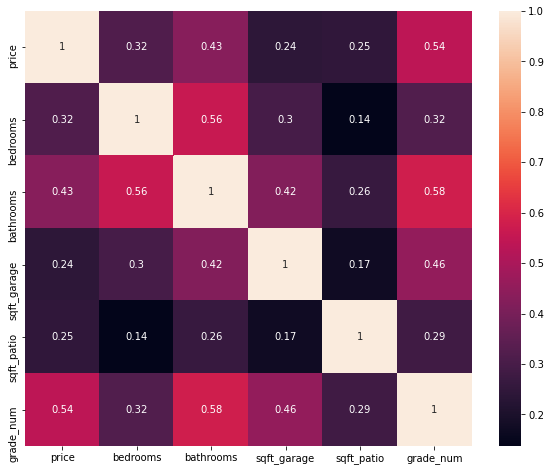

In [11]:
# Correlation heatmap for intial cleansed dataset

fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(df_model_iqr.corr(), annot=True);